# *LEAF DISEASE DETECTION USING OPENCV AND MACHINE LEARNING*

In [38]:
import os, shutil
from sklearn.model_selection import train_test_split

DATASET_DIR = "leafdisease dataset"
OUTPUT_DIR = "final_leaf_dataset"

# Create train/val directories
for split in ["train", "val"]:
    for cls in os.listdir(DATASET_DIR):
        os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

# Split each class folder
for cls in os.listdir(DATASET_DIR):
    cls_path = os.path.join(DATASET_DIR, cls)
    images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg','.jpeg','.png'))]

    if len(images) == 0:
        print(f"⚠️ Skipping {cls} (no images found)")
        continue

    # Train/val split (80/20)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Copy files
    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(OUTPUT_DIR, "train", cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(OUTPUT_DIR, "val", cls, img))

print(" Dataset split complete!")


⚠️ Skipping .ipynb_checkpoints (no images found)
 Dataset split complete!


In [39]:
# Install dependencies
!pip install tensorflow gradio scikit-learn matplotlib

import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [40]:
TRAIN_DIR = "/content/final_leaf_dataset/train"
VAL_DIR   = "/content/final_leaf_dataset/val"
MODEL_PATH = "leaf_model.h5"
LABELS_PATH = "class_labels.json"
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 20


In [41]:
# Verify classes and counts
def count_images(root):
    totals = {}
    for cls in sorted(os.listdir(root)):
        p = os.path.join(root, cls)
        if os.path.isdir(p):
            n = sum(1 for f in os.listdir(p) if f.lower().endswith(('.jpg','.jpeg','.png')))
            totals[cls] = n
    return totals

train_counts = count_images(TRAIN_DIR)
val_counts   = count_images(VAL_DIR)

print("Train counts:", train_counts)
print("Val counts:", val_counts)

# Image generators with augmentation for small datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Persist class label order for inference
class_labels = list(train_gen.class_indices.keys())
with open(LABELS_PATH, "w") as f:
    json.dump(class_labels, f)
print("Class labels:", class_labels)


Train counts: {'.ipynb_checkpoints': 0, 'Bacterial_Spot': 2, 'Early_Blight': 3, 'Late_Blight': 3, 'healthy': 2}
Val counts: {'.ipynb_checkpoints': 0, 'Bacterial_Spot': 1, 'Early_Blight': 1, 'Late_Blight': 1, 'healthy': 1}
Found 10 images belonging to 5 classes.
Found 4 images belonging to 5 classes.
Class labels: ['.ipynb_checkpoints', 'Bacterial_Spot', 'Early_Blight', 'Late_Blight', 'healthy']


In [42]:
# Simple CNN baseline
model = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1000 - loss: 1.6322
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to leaf_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1000 - loss: 1.6322 - val_accuracy: 0.2500 - val_loss: 1.5833 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.2000 - loss: 1.5292
Epoch 2: val_accuracy did not improve from 0.25000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 1.5292 - val_accuracy: 0.2500 - val_loss: 1.6391 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2000 - loss: 1.5898
Epoch 3: val_accuracy did not improve from 0.25000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 1.5898 - val_accuracy: 0.2500 - val_loss: 1.4467 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3000 - loss: 1.3315
Epoch 4: val_accuracy did not improve from 0.25000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3000 - loss: 1.3315 - val_accuracy: 0.2500 - val_loss: 1.3860 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4000 - loss: 1.3646 - val_accuracy: 0.5000 - val_loss: 1.3534 - learning_rate: 0.0010
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.4000 - loss: 1.2879
Epoch 6: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 1.2879 - val_accuracy: 0.2500 - val_loss: 1.3704 - learning_rate: 0.0010
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5000 - loss: 1.1921
Epoch 7: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.1921 - val_accuracy: 0.2500 - val_loss: 1.4488 - learning_rate: 0.0010
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4000 - loss: 1.1642
Epoch 8: val_accuracy did not improve from 0.50000

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 1.1642 - val_accuracy: 0.2500 - val_loss: 1.3551 -

Model saved to leaf_model.h5


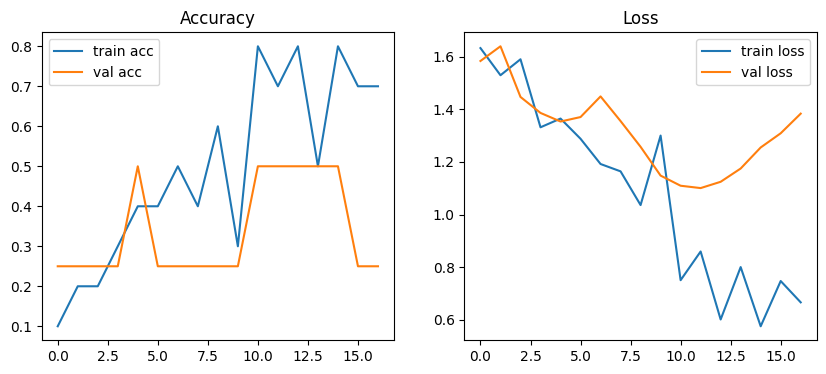

In [43]:
# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

Classification report:
                precision    recall  f1-score   support

Bacterial_Spot     0.0000    0.0000    0.0000         1
  Early_Blight     0.5000    1.0000    0.6667         1
   Late_Blight     1.0000    1.0000    1.0000         1
       healthy     0.0000    0.0000    0.0000         1

      accuracy                         0.5000         4
     macro avg     0.3750    0.5000    0.4167         4
  weighted avg     0.3750    0.5000    0.4167         4



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


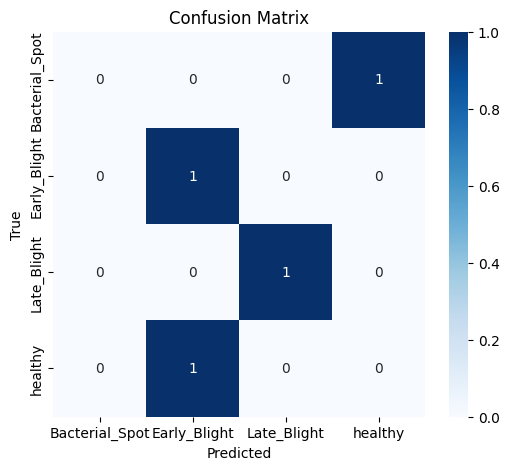

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
pred_probs = model.predict(val_gen)
pred_idxs = np.argmax(pred_probs, axis=1)
true_idxs = val_gen.classes

# Ensure labels match dataset
labels = list(val_gen.class_indices.keys())

# Use np.unique to auto-match classes
unique_classes = np.unique(true_idxs)

print("\nClassification report:")
print(classification_report(true_idxs, pred_idxs,
                            labels=unique_classes,
                            target_names=[labels[i] for i in unique_classes],
                            digits=4))

# Confusion matrix
cm = confusion_matrix(true_idxs, pred_idxs, labels=unique_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[labels[i] for i in unique_classes],
            yticklabels=[labels[i] for i in unique_classes])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


In [45]:
# Load model and labels for inference
model = load_model(MODEL_PATH)
with open(LABELS_PATH, "r") as f:
    class_labels = json.load(f)

# Simple treatment mapping
medicines = {
    'healthy': 'No medicine required. Maintain proper watering and nutrition.',
    'Bacterial_Spot': 'Apply Copper Oxychloride or Mancozeb. Remove infected leaves.',
    'Early_Blight': 'Use Chlorothalonil (Daconil) or Mancozeb. Improve airflow.',
    'Late_Blight': 'Apply Metalaxyl/Ridomil Gold. Avoid overhead irrigation.'
}

def preprocess_np(img_np):
    img_resized = cv2.resize(img_np, IMG_SIZE) / 255.0
    return np.expand_dims(img_resized, axis=0)

def predict_image_np(img_np):
    x = preprocess_np(img_np)
    probs = model.predict(x)[0]
    idx = int(np.argmax(probs))
    cls = class_labels[idx]
    conf = float(np.max(probs)) * 100
    treatment = medicines.get(cls, "Consult local agronomy guidance.")
    return cls, conf, treatment


In [49]:
import gradio as gr

def gradio_fn(img):
    # img comes as numpy RGB
    cls, conf, treatment = predict_image_np(img)
    return f"Disease: {cls}\nConfidence: {conf:.2f}%\nTreatment: {treatment}"

demo = gr.Interface(
    fn=gradio_fn,
    inputs=gr.Image(type="numpy", label="Upload leaf image"),
    outputs=gr.Textbox(label="Prediction", lines=10, max_lines=20),  # 🔹 Bigger box
    title="Leaf Disease Detection",
    description="Classifies leaf images into Healthy, Bacterial_Spot, Early_Blight, Late_Blight and suggests basic treatment."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://143b41aa03a547ebc6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
